In [104]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
import xgboost as xgb 
import shap
import os 
import sys 
import warnings 

from sklearn import linear_model 
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

In [55]:
shap.initjs()

In [56]:
sample = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

# Data study

In [58]:
train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


Plotting structure of train data.

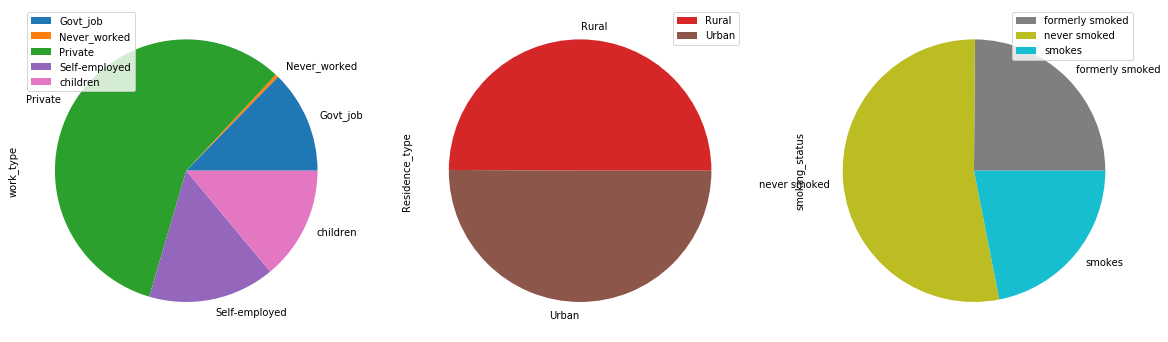

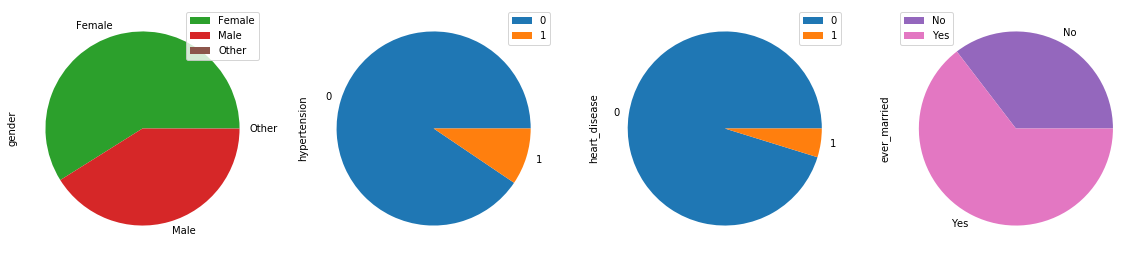

In [79]:
train[['work_type',
       'Residence_type',
       'smoking_status']].apply(lambda x:x.value_counts()).plot.pie(subplots = True, figsize = (20, 10))

train[['gender', 
       'hypertension',
       'heart_disease', 
       'ever_married']].apply(lambda x: x.value_counts()).plot.pie(subplots = True, figsize = (20, 10))
plt.show()

And numeric ones. 

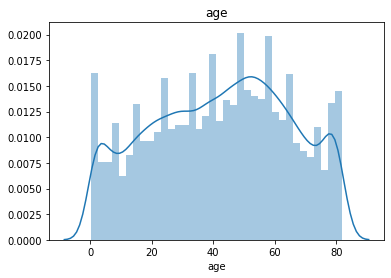

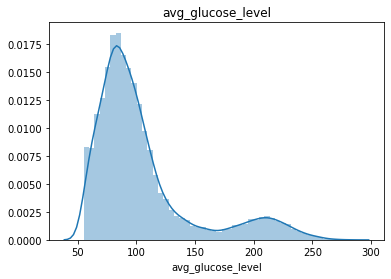

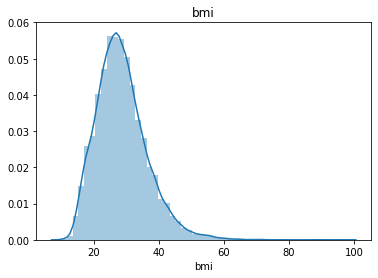

In [81]:
for i in ['age', 'avg_glucose_level', 'bmi']: 
    ax = sns.distplot(train[i].dropna())
    ax.set_title(i)
    plt.show()

And class labels. 

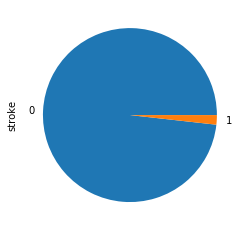

In [82]:
train['stroke'].value_counts().plot.pie()

# Data prep 

Preparing data for ML: relabeling and ordering categorical factors, filling na values. 

In [83]:
#auto relabel
for col in ['Residence_type', 'ever_married']:
    train[col] = train[col].map({item:idx for idx, item in pd.Series(train[col].unique()).iteritems()})
    train[col] = train[col].fillna(train[col].mean())

#instead of automatic remapping I chose for some features manual dicts as this reflects order of factors

train['work_type'] = train['work_type'].map({'Never_worked':0, 'Self-employed':1, 
                                             'children':2, 'Private':3, 'Govt_job': 4})

#actually this is an example of bad feature, as formely smoked and smokes does not reflect time and amount smoked
#but as geo database teaches us, bioinformatics is suffering
#batches and suffering, to be more precise
train['smoking_status'] = train['smoking_status'].map({'never smoked': 0, 'formerly smoked': 1, 'smokes': 2})


train['gender'] = train['gender'].map({'Male': 0, 'Female': 1}) #other gender is na gender 

for col in ['gender', 'smoking_status', 'work_type']:
    train[col] = train[col].fillna(train[col].mean())

In [84]:
#and test

#auto relabel
for col in ['Residence_type', 'ever_married']:
    test[col] = test[col].map({item:idx for idx, item in pd.Series(test[col].unique()).iteritems()})
    test[col] = test[col].fillna(train[col].mean())

#instead of automatic remapping I chose for some features manual dicts as this reflects order of factors

test['work_type'] = test['work_type'].map({'Never_worked':0, 'Self-employed':1, 'children':2, 'Private':3, 'Govt_job': 4})

#suffering, I repeat
test['smoking_status'] = test['smoking_status'].map({'never smoked': 0, 'formerly smoked': 1, 'smokes': 2})


test['gender'] = test['gender'].map({'Male': 0, 'Female': 1}) #other gender is na gender 

for col in ['gender', 'smoking_status', 'work_type']:
    test[col] = test[col].fillna(train[col].mean())

In [85]:
mean_bmi = train['bmi'].mean()
train['bmi'] = train['bmi'].fillna(mean_bmi)
test['bmi'] = test['bmi'].fillna(mean_bmi)

In [86]:
features_list = ['age', 'avg_glucose_level', 'bmi',
                 'hypertension', 'heart_disease', 'smoking_status',
                 'gender', 'work_type']
#, 'Residence_type', 'ever_married'

# Logistic  

Here I do cv feature selection and hyperparameter tuning before and after. Perfectly, hyperparameter retuning would be performed after each feature selection step (this, however, would require custom FS function, not sklearn one), but here I forgo it because of low number of features and because I won't hang long with logistic regression anyway 

Here as it is toy example and this code is meant to be rerun quite a lot, I use small grid for hyperparameter search: no changes in eta scheme, no elastic net. This could be easily added, however. 

Balancing classes, as I checked, gives worse AUC metrics, although it enhances previously nigh-zero performance at F1 and accuracy levels. This happens because test and train are imbalanced and AUC is not actually best metrics to evaluate performance in this case. Yet since it is leaderboard metrics, I choose AUC as scoring and forgo balancing classes. Yeah, I do feel ashamed for this. 



In [11]:
splitter = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)

param_grid = {
    'max_iter': [500, 1000, 3000],
    'penalty': ['l1', 'l2'],
    'alpha': [0.0001, 0.000001, 0.01], 
    'tol': [0.001, 0.01, 0.0005],
    
}

#class_weight = 'balanced' 
#balance could have  looked like this 
grid = GridSearchCV(estimator = linear_model.SGDClassifier(loss='log'),
                    param_grid = param_grid,
                    verbose = 2, 
                    scoring = 'roc_auc',
                    cv = splitter,
                    n_jobs = 4)

result = grid.fit(train[features_list], train['stroke'])
print(result.best_score_)
print(result.best_params_)

clf = linear_model.SGDClassifier(loss='log', **result.best_params_)

feature_selection = RFECV(clf, step=1, min_features_to_select=1, cv=splitter, verbose=3, scoring= 'roc_auc')

feature_selection.fit(train[features_list], train['stroke'])

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   19.6s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  1.3min finished


0.8251539848516477
{'alpha': 0.0001, 'max_iter': 1000, 'penalty': 'l1', 'tol': 0.001}
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitt

RFECV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
      estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                              early_stopping=False, epsilon=0.1, eta0=0.0,
                              fit_intercept=True, l1_ratio=0.15,
                              learning_rate='optimal', loss='log',
                              max_iter=1000, n_iter_no_change=5, n_jobs=None,
                              penalty='l1', power_t=0.5, random_state=None,
                              shuffle=True, tol=0.001, validation_fraction=0.1,
                              verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='roc_auc', step=1,
      verbose=3)

Optimal number of features : 5


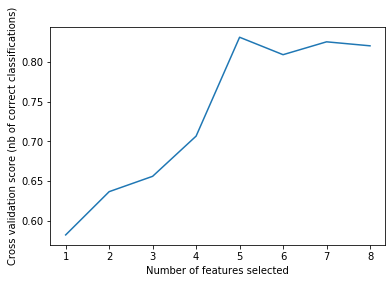

In [12]:
#rip off from sklearn tutorial for depiction

print("Optimal number of features : %d" % feature_selection.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(feature_selection.grid_scores_) + 1), feature_selection.grid_scores_)
plt.show()

In [13]:
#transforming data 
train_data = feature_selection.transform(train[features_list])
train_data = pd.DataFrame(train_data, index = train.index)
test_data = feature_selection.transform(test[features_list])
test_data = pd.DataFrame(test_data, index = test.index)

In [14]:
result = grid.fit(train_data, train['stroke']) 

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    6.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   20.3s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  1.1min finished


In [15]:
print(result.best_score_)
print(result.best_params_)

0.8400928764115958
{'alpha': 1e-06, 'max_iter': 500, 'penalty': 'l1', 'tol': 0.01}


In [16]:
prediction = result.predict_proba(test_data)[:,1]

In [17]:
sample['stroke'] = prediction

In [18]:
sample.to_csv('submit1.csv', index = None )

AUC on test = 0.85193
This varies +- 0.03, depending on random seeds, actually. 
Anyway, to features study. 

Be it  R, explaining features of logistic regression would have been more fun, because it has nice stat and graphical packages and functions for that, but I will have to do with python coefs for now. 

In [19]:
#first need to get their names 

mask = pd.Series(feature_selection.support_, index = features_list)
print(mask)

age                   True
avg_glucose_level    False
bmi                   True
hypertension          True
heart_disease         True
smoking_status        True
gender               False
work_type            False
dtype: bool


In [20]:
coefs = pd.Series(result.best_estimator_.coef_[0] , mask[mask].index)
print(coefs)

age                22.449318
bmi                 3.694220
hypertension       75.634028
heart_disease     131.376619
smoking_status     84.243810
dtype: float64


- Bigger ages and bmis work towards stroke. 
- Having hypertension and heart diseases also increases risk. 
- Smoking increases risk either, yet since feature is not that good, can't speak of difference between smokers and former smokers 

# K-neighbors 

Doing random forest when I have gradient boosting later would be boring, and decision tree certainly will not perform well. So I chose K-neighbors.  

K-neighbors does not return any feature importances which makes impossible classic feature selection, however it is possible to infer feature importance from performance decrease after a feature is deleted. Thus sort of feature selection still can be apllied.

In [92]:
def delete_feature(delete_this, train_data, train_labels, grid): 
    '''
    Fits classifier for all features except one, gets best cv score
    :param: delete_this: str, feature to delete 
    :param: train_data: pd.Dataframe train data, columns - features
    :param: train_labels: pd.Series train labels 
    :param: grid: GridSearchCV sklearn object 
    :returns: cv_score: float, cross validation score after deletion of featire
    
    '''
    train_data = train_data.drop(delete_this, axis = 1)
    result = grid.fit(train_data, train_labels)
    cv_score = result.best_score_
    return cv_score

In [93]:
def FS_elimination_step(train_data, train_labels, grid):
    '''
    Deletes every feature, checking which one is least important 
    :param: train_data: pd.Dataframe train data, columns - features
    :param: train_labels: pd.Series train labels 
    :param: grid: GridSearchCV sklearn object 
    :returns: importance_df: 
    
    '''
    
    feature_importance = {}
    #iterating through features 
    for feature in train_data.columns:
        feature_importance[feature] = delete_feature(feature, train_data, train_labels, grid)
        
    #sorting. The bigger is cv_score, the less important was the feature. First in following list will be the least important
    #I take step of 1    
    feature_importance = pd.Series(feature_importance).sort_values(ascending=False)    
    
    new_features = feature_importance[1:].index
    
    return new_features, feature_importance[0]

In [95]:
features_limit = 3
cv_vs_total = {}

splitter = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)

small_param_grid = {
    'n_neighbors': [10, 30, 100, 200],
    'weights': ['uniform', 'distance'],
    'leaf_size': [10, 30, 60], 
    'p': [1,2]
}


grid = GridSearchCV(estimator = KNeighborsClassifier(),
                    param_grid = small_param_grid,
                    verbose = 2, 
                    scoring = 'roc_auc',
                    cv = splitter,
                    n_jobs = 5)


#zero iteration
features = features_list
result = grid.fit(train[features], train['stroke'])
cv_score = result.best_score_
cv_vs_total[len(features)] = [cv_score, features]
print(len(features), cv_score)  

#eliminating features
    
while len(features) > features_limit:
    
    #fit and select
    features, cv_score = FS_elimination_step(train[features], train['stroke'], grid)
    cv_vs_total[len(features)] = [cv_score, features]
    print(len(features), cv_score)   

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:   11.0s
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed:   23.8s
[Parallel(n_jobs=5)]: Done 480 out of 480 | elapsed:   33.5s finished


8 0.8394712304441425
Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:   10.2s
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed:   21.3s
[Parallel(n_jobs=5)]: Done 480 out of 480 | elapsed:   29.1s finished


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    3.2s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:   11.1s
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed:   21.3s
[Parallel(n_jobs=5)]: Done 480 out of 480 | elapsed:   29.0s finished


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:    8.9s
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed:   17.0s
[Parallel(n_jobs=5)]: Done 480 out of 480 | elapsed:   23.3s finished


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:   10.4s
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed:   21.2s
[Parallel(n_jobs=5)]: Done 480 out of 480 | elapsed:   30.9s finished


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:   11.1s
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed:   22.7s
[Parallel(n_jobs=5)]: Done 480 out of 480 | elapsed:   32.7s finished


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    3.6s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:   12.3s
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed:   23.4s
[Parallel(n_jobs=5)]: Done 480 out of 480 | elapsed:   32.1s finished


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    3.7s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:   13.2s
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed:   25.3s
[Parallel(n_jobs=5)]: Done 480 out of 480 | elapsed:   34.3s finished


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:   10.6s
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed:   21.4s
[Parallel(n_jobs=5)]: Done 480 out of 480 | elapsed:   30.3s finished


7 0.8397753341857449
Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    2.8s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:    9.6s
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed:   18.8s
[Parallel(n_jobs=5)]: Done 480 out of 480 | elapsed:   26.2s finished


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    2.8s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:    9.7s
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed:   18.9s
[Parallel(n_jobs=5)]: Done 480 out of 480 | elapsed:   26.3s finished


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    2.8s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:    9.5s
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed:   18.5s
[Parallel(n_jobs=5)]: Done 480 out of 480 | elapsed:   27.9s finished


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    3.5s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:   10.9s
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed:   21.2s
[Parallel(n_jobs=5)]: Done 480 out of 480 | elapsed:   29.8s finished


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    3.4s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:    9.6s
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed:   18.2s
[Parallel(n_jobs=5)]: Done 480 out of 480 | elapsed:   24.6s finished


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:   10.9s
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed:   20.6s
[Parallel(n_jobs=5)]: Done 480 out of 480 | elapsed:   28.6s finished


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    4.3s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:   10.9s
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed:   20.0s
[Parallel(n_jobs=5)]: Done 480 out of 480 | elapsed:   27.0s finished


6 0.8397289194449366
Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:    9.5s
[Parallel(n_jobs=5)]: Done 480 out of 480 | elapsed:   24.4s finished


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:    9.6s
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed:   19.0s
[Parallel(n_jobs=5)]: Done 480 out of 480 | elapsed:   26.6s finished


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:   10.7s
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed:   20.4s
[Parallel(n_jobs=5)]: Done 480 out of 480 | elapsed:   28.7s finished


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    3.3s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:    8.6s
[Parallel(n_jobs=5)]: Done 360 tasks      | elapsed:   17.5s
[Parallel(n_jobs=5)]: Done 480 out of 480 | elapsed:   24.6s finished


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    2.8s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:    9.4s
[Parallel(n_jobs=5)]: Done 480 out of 480 | elapsed:   23.0s finished


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    2.7s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:    8.3s
[Parallel(n_jobs=5)]: Done 471 out of 480 | elapsed:   20.3s remaining:    0.3s
[Parallel(n_jobs=5)]: Done 480 out of 480 | elapsed:   20.9s finished


5 0.8390883814868684
Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    2.6s
[Parallel(n_jobs=5)]: Done 264 tasks      | elapsed:   11.4s
[Parallel(n_jobs=5)]: Done 480 out of 480 | elapsed:   20.5s finished


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    2.6s
[Parallel(n_jobs=5)]: Done 264 tasks      | elapsed:   11.1s
[Parallel(n_jobs=5)]: Done 480 out of 480 | elapsed:   20.3s finished


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    2.6s
[Parallel(n_jobs=5)]: Done 264 tasks      | elapsed:    9.0s
[Parallel(n_jobs=5)]: Done 480 out of 480 | elapsed:   16.0s finished


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    2.6s
[Parallel(n_jobs=5)]: Done 264 tasks      | elapsed:    9.8s
[Parallel(n_jobs=5)]: Done 480 out of 480 | elapsed:   17.4s finished


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    2.7s
[Parallel(n_jobs=5)]: Done 259 tasks      | elapsed:    9.3s
[Parallel(n_jobs=5)]: Done 471 out of 480 | elapsed:   16.6s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 480 out of 480 | elapsed:   17.0s finished


4 0.8387026447640531
Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 264 tasks      | elapsed:   10.8s
[Parallel(n_jobs=5)]: Done 480 out of 480 | elapsed:   18.9s finished


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 471 out of 480 | elapsed:   13.8s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 480 out of 480 | elapsed:   14.0s finished


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 480 out of 480 | elapsed:   14.6s finished


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 471 out of 480 | elapsed:   14.6s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 480 out of 480 | elapsed:   14.8s finished


3 0.8370985748268623


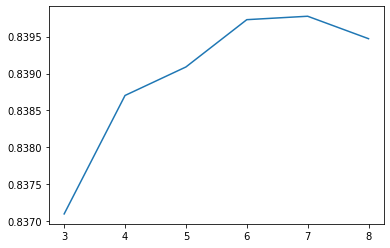

In [96]:
#feature importance plot

cvs = {}
for i in cv_vs_total: 
    cvs[i] = cv_vs_total[i][0]
cvs = pd.Series(cvs)
a = plt.plot(cvs)
plt.show()

In [99]:
features_selected = cv_vs_total[cvs.idxmax()][1]

In [101]:
param_grid = {
    'n_neighbors': [5, 10, 30, 50, 100, 200],
    'weights': ['uniform', 'distance'],
    'leaf_size': [10, 30, 60], 
    'p': [1,2]
}


grid = GridSearchCV(estimator = KNeighborsClassifier(),
                    param_grid = param_grid,
                    verbose = 2, 
                    scoring = 'roc_auc',
                    cv = splitter,
                    n_jobs = 4)

result = grid.fit(train[features_selected], train['stroke'])
print(result.best_score_)
print(result.best_params_)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 264 tasks      | elapsed:   16.4s
[Parallel(n_jobs=4)]: Done 670 tasks      | elapsed:   36.7s
[Parallel(n_jobs=4)]: Done 713 out of 720 | elapsed:   41.2s remaining:    0.3s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:   41.7s finished


0.8397753341857449
{'leaf_size': 60, 'n_neighbors': 200, 'p': 1, 'weights': 'uniform'}


In [103]:
prediction = result.predict_proba(test[features_selected])[:,1]
sample['stroke'] = prediction
sample.to_csv('submit1.csv', index = None )

Did 0.84275 AUC on test set. Since classifier does not return feature importance, I will plot data PCA-projection to see how predictor works. 

In [122]:
#pca transformation
pca = PCA(n_components=2)
data = pca.fit_transform(train[features_selected])

In [123]:
data = pd.DataFrame(data)
data['label'] = train['stroke']
data['prediction'] = result.predict_proba(train[features_selected])[:,1]

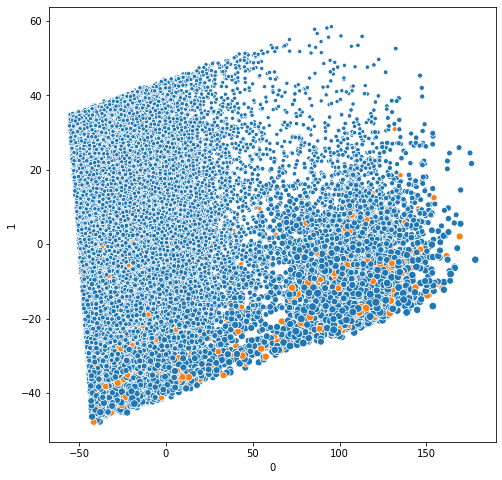

In [131]:
ax, fig = plt.subplots(1, 1, figsize = (8, 8))
sns.scatterplot(data = data, x = 0, y = 1, size = data['prediction'], hue = 'label', legend = False)
plt.show()

Also can get sort of  feature importance with elimination.

In [138]:
params = result.best_params_

In [139]:
feature_importance = {}
#iterating through features

#to parallel cv
param_grid = {}
grid = GridSearchCV(estimator = KNeighborsClassifier(**params),
                    param_grid = param_grid,
                    verbose = 2, 
                    scoring = 'roc_auc',
                    cv = splitter,
                    n_jobs = 4)

for feature in features_selected:
    res = grid.fit(train[features_selected].drop(feature, axis = 1), train['stroke'])
    feature_importance[feature] = res.best_score_
        
feature_importance = pd.Series(feature_importance).sort_values(ascending=False) 

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    4.4s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    3.0s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    2.9s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    2.8s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    2.6s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    2.8s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    2.7s finished


In [140]:
print(feature_importance)

heart_disease        0.839727
work_type            0.838717
smoking_status       0.838237
gender               0.836775
bmi                  0.835611
avg_glucose_level    0.824794
age                  0.684182
dtype: float64


Age is most important feature, while all others are far less important. 

# Gradient boosting (xgboost)

What time is this? - It is gradient boosting time.

Here I perform feature selection with hyperparameter search after each step, using shap importances instead of standard gain or etc. I use shap package https://github.com/slundberg/shap to describe feature imporances and to see the direction of each feature. 

In [33]:
def one_elimination_step(train_dataset, train_labels, grid):
    '''
    Fits classifier for current number of features, gets shap importances and cv score 
    :param: data_train: pd.Dataframe train data, columns - features
    :param: labels_train: pd.Series train labels 
    :param: features_left: list features in work
    :param: grid: GridSearchCV sklearn object 
    :returns: importance_df: 
    
    '''

    #grid search
    result = grid.fit(train_dataset, train_labels)
    l_model = grid.best_estimator_
    cv_score = grid.best_score_
    print(cv_score)
    
    #get_importance
    
    explainer = shap.TreeExplainer(l_model)
    shap_values = explainer.shap_values(train_dataset)
    shap_sum = np.abs(shap_values).mean(axis=0)
    importance_df = pd.DataFrame([train_dataset.columns.tolist(), shap_sum.tolist()]).T
    importance_df.columns = ['column_name', 'importance']
    importance_df = importance_df.sort_values('importance', ascending=False)
    
    return importance_df, cv_score

In [35]:
cv_vs_total = {}
   
features_limit = 2
step = 1

#small param grid 
param_grid = {
'min_child_weight': [1, 3, 6, 9],
'learning_rate': [0.05, 0.1, 0.2],
'gamma': [0, 0.1, 0.25, 0.4]
}

splitter = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)    

grid = GridSearchCV(
    xgb.XGBClassifier(subsample = 0.85, n_estimators = 100, max_depth = 3, reg_alpha = 0),
    param_grid,
    scoring="neg_log_loss", #gonna get away from auc for a bit 
    n_jobs=5, cv = splitter, verbose = 2)

#zero iteration
features = features_list
importance_df, cv_score = one_elimination_step(train[features], train['stroke'], grid)
cv_vs_total[len(features)] = [cv_score, features]
print(len(features), cv_score)  

#eliminating features
    
while len(features) > features_limit:
    
    #fit and select
    
    features = importance_df['column_name'][:-step]
    importance_df, cv_score = one_elimination_step(train[features], train['stroke'], grid)
    cv_vs_total[len(features)] = [cv_score, features]
    print(len(features), cv_score)    
       

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   17.4s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:  1.3min
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed:  2.9min
[Parallel(n_jobs=5)]: Done 480 out of 480 | elapsed:  3.9min finished


-0.07277053156425105
8 -0.07277053156425105
Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   16.4s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:  1.2min
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed:  2.7min
[Parallel(n_jobs=5)]: Done 480 out of 480 | elapsed:  3.7min finished


-0.07279449039310029
7 -0.07279449039310029
Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   16.0s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:  1.1min
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed:  2.4min
[Parallel(n_jobs=5)]: Done 480 out of 480 | elapsed:  3.3min finished


-0.07278791567227566
6 -0.07278791567227566
Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   15.3s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:  1.0min
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed:  2.3min
[Parallel(n_jobs=5)]: Done 480 out of 480 | elapsed:  3.1min finished


-0.07278951379803472
5 -0.07278951379803472
Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   14.4s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:   57.1s
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed:  2.2min
[Parallel(n_jobs=5)]: Done 480 out of 480 | elapsed:  2.9min finished


-0.0729740940267517
4 -0.0729740940267517
Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   13.1s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:   53.0s
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed:  2.0min
[Parallel(n_jobs=5)]: Done 480 out of 480 | elapsed:  2.6min finished


-0.07304715492948512
3 -0.07304715492948512
Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   11.8s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:   45.7s
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed:  1.8min
[Parallel(n_jobs=5)]: Done 480 out of 480 | elapsed:  2.4min finished


-0.0743917072594882
2 -0.0743917072594882


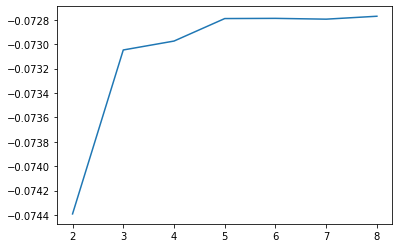

In [37]:
#feature importance plot

cvs = {}
for i in cv_vs_total: 
    cvs[i] = cv_vs_total[i][0]
cvs = pd.Series(cvs)
a = plt.plot(cvs)
plt.show()

In [38]:
cvs.idxmax()

8

In [45]:
#bigger selection
param_grid = {
    'max_depth': [3, 4],
    'n_estimators': [100, 300],
    'reg_alpha': [0, 1],
    'min_child_weight': range(1, 7, 2),
    'learning_rate': [0.05, 0.1, 0.2, 0.3],
    'gamma': [0, 0.05, 0.1, 0.25]}


grid = GridSearchCV(
    xgb.XGBClassifier(subsample = 0.85),
    param_grid,
    scoring="neg_log_loss",
    n_jobs=5, cv = splitter, verbose = 2)

In [46]:
result = grid.fit(train[features_list], train['stroke'])

Fitting 10 folds for each of 384 candidates, totalling 3840 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   36.2s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:  2.5min
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed:  5.7min
[Parallel(n_jobs=5)]: Done 638 tasks      | elapsed: 10.4min
[Parallel(n_jobs=5)]: Done 1003 tasks      | elapsed: 16.3min
[Parallel(n_jobs=5)]: Done 1448 tasks      | elapsed: 23.4min
[Parallel(n_jobs=5)]: Done 1975 tasks      | elapsed: 31.9min
[Parallel(n_jobs=5)]: Done 2582 tasks      | elapsed: 41.7min
[Parallel(n_jobs=5)]: Done 3271 tasks      | elapsed: 53.2min
[Parallel(n_jobs=5)]: Done 3840 out of 3840 | elapsed: 62.8min finished


In [47]:
print(result.best_score_)
print(result.best_params_)

-0.07263316466788157
{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'reg_alpha': 1}


In [48]:
explainer = shap.TreeExplainer(result.best_estimator_)
shap_values = explainer.shap_values(train[features_list])

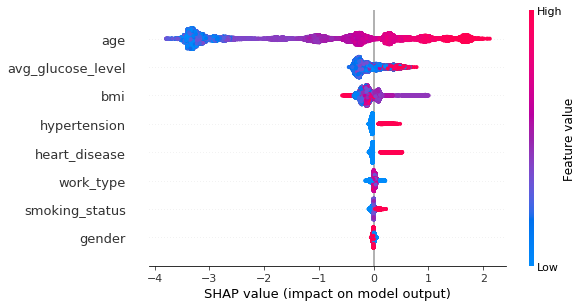

In [49]:
shap.summary_plot(shap_values, train[features_list])

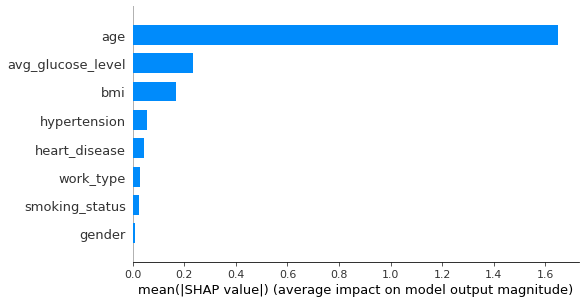

In [51]:
shap.summary_plot(shap_values, train[features_list], plot_type = 'bar')

In [52]:
prediction = result.predict_proba(test[features_list])[:,1]
sample['stroke'] = prediction
sample.to_csv('submit1.csv', index = None )

AUC on test = 0.87037. GJ, xgboost. 

All features seem to work towards stroke (exception bmi and gender), with age being most significant.